In [1]:
import os
import sys 
sys.path.append('../../utilities/')
import data_utils, evaluation_utils
sys.path.append('../../src')
from dataset_class import dataset
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn import metrics
from hmmlearn import hmm

/home/nedooshki/miniconda3/envs/IChDA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
functional_stats = evaluation_utils.stats(paths['HMM_joint'], 100000, gene_expression_path, RT_path, 
                                   CTCF_bedpe_path, RNAPII_bedpe_path)
joint_stats['method'] = 'HMM'
joint_stats['input_type'] = 'joint'
joint_stats = pd.DataFrame([joint_stats])

In [3]:
gene_expression_path = '../../data/K562/hg19/gene_expression/K562_genes_RPKM.txt'
RT_path = '../../data/K562/hg19/RT/six_phase/six_phases.txt'

In [2]:
signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
K562_dataset = dataset('K562', 'hg19', 100000, '',
                 '../../utilities/juicer_tools_1.22.01.jar', '../../data/K562/hg19/Hi-C/res100000',
                 signals_names, '../../data/K562/hg19/genomic-assays/bin_100000/', 
                  '../../data/K562/hg19/res100000_datasets/',
                  '../../data/', '../../utilities/config.json')
K562_dataset.load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/K562_100000_bins.txt')

In [3]:
#structural_df = K562_dataset.read_line_embedding('../../data/K562/hg19/res100000_datasets/embeddings/sci/sci_d{8}_s{100}_o{2}.txt', 8, 0)
#structural_signals = np.array(structural_df.loc[:,['emb{}'.format(e) for e in np.arange(1,9)]])
structural_signals_path = "../../data/K562/hg19/res100000_datasets/structural_signals.txt"
structural_signals = np.loadtxt(structural_signals_path)

functional_signals_path = "../../data/K562/hg19/res100000_datasets/signals.txt"
functional_signals = np.loadtxt(functional_signals_path)

combined_signals = np.concatenate([functional_signals, structural_signals], axis = 1)

TSA_signals = K562_dataset.valid_bins_df.copy()
Lamin_df = pd.read_csv('../../data/K562/hg19/genomic-assays/bin_100000/LaminA_TSA-seq.bedgraph', sep = "\t", header = None)
Lamin_df.columns = ['chr_name', 'start', 'end', 'LaminA']
TSA_signals = TSA_signals.merge(Lamin_df, on = ['chr_name', 'start', 'end'], how = 'left')
TSA_signals.drop_duplicates(subset=['index'], keep = 'first', inplace = True)
SON_df = pd.read_csv('../../data/K562/hg19/genomic-assays/bin_100000/SON_TSA-seq.bedgraph', sep = "\t", header = None)
SON_df.columns = ['chr_name', 'start', 'end', 'SON']
TSA_signals = pd.merge(TSA_signals, SON_df, on = ['chr_name', 'start', 'end'], how = 'left')
TSA_signals.drop_duplicates(subset=['index'], keep = 'first', inplace = True)

signals_df = pd.DataFrame(np.concatenate([np.array(TSA_signals[['LaminA', 'SON']]), functional_signals], axis = 1))
signals_df.columns = ['LaminA', 'SON'] + signals_names

#signals_df = pd.concat([signals_df,RT_df[['G1', 'S1', 'S2', 'S3', 'S4', 'G2']]], axis = 1)

In [4]:
annotation_dir = "../../data/K562/hg19/res100000_datasets/annotations"
annot_dir = os.path.join(annotation_dir, 'k6')

In [5]:
paths = {}
paths['HMM_functional'] = os.path.join(annot_dir, 'HMM_functional_annotation.txt')
paths['HMM_structural'] = os.path.join(annot_dir, 'HMM_structural_annotation.txt')
paths['HMM_combined'] = os.path.join(annot_dir, 'HMM_combined_annotation.txt')
paths['SC'] = '../../data/K562/hg19/annotations/K562_SNIPER.bed'
for key in paths.keys():
    K562_dataset.read_annotation(paths[key], key)

In [6]:
signals_labels_df = signals_df.copy()
signals_labels_df['HMM_functional'] = K562_dataset.labels['HMM_functional']
signals_labels_df['HMM_structural'] = K562_dataset.labels['HMM_structural']
signals_labels_df['HMM_combined'] = K562_dataset.labels['HMM_combined']
signals_labels_df['SC'] = K562_dataset.labels['SC']
signals_labels_df = signals_labels_df.replace(to_replace='None', value=np.nan).dropna()
#signals_labels_df = signals_labels_df[signals_labels_df['SC']!='NA']
#signals_labels_df = signals_labels_df[signals_labels_df['SC']!='B4']LaminA_active1 = signals_labels_df[signals_labels_df['HMM_functional'] == '1']['LaminA'].values
LaminA_active2 = signals_labels_df[signals_labels_df['HMM_functional'] == '4']['LaminA'].values

In [17]:
LaminA_active1 = signals_labels_df[signals_labels_df['HMM_functional'] == '1']['LaminA'].values
LaminA_active2 = signals_labels_df[signals_labels_df['HMM_functional'] == '4']['LaminA'].values

In [19]:
from scipy import stats
stats.ttest_ind(a=LaminA_active2, b=LaminA_active1, equal_var=False)

Ttest_indResult(statistic=12.617934231146497, pvalue=3.9877866100936705e-36)

In [22]:
LaminA_active1 = signals_labels_df[signals_labels_df['HMM_structural'] == '5']['LaminA'].values
LaminA_active2 = signals_labels_df[signals_labels_df['HMM_structural'] == '1']['LaminA'].values

In [23]:
from scipy import stats
stats.ttest_ind(a=LaminA_active2, b=LaminA_active1, equal_var=False)

Ttest_indResult(statistic=42.3300042839238, pvalue=0.0)

In [20]:
LaminA_active1 = signals_labels_df[signals_labels_df['SC'] == 'A1']['LaminA'].values
LaminA_active2 = signals_labels_df[signals_labels_df['SC'] == 'A2']['LaminA'].values

In [21]:
from scipy import stats
stats.ttest_ind(a=LaminA_active2, b=LaminA_active1, equal_var=False)

Ttest_indResult(statistic=101.9222146190452, pvalue=0.0)

In [10]:
enrichments = {}
orders = {}
expr_stats = {}
coverages = {}
overlaps = {}
pvalues = {}

for method in ['HMM_functional', 'HMM_structural', 'HMM_combined', 'SC']:
    enrichments[method] = evaluation_utils.enrichment_scores_(signals_labels_df,
                                                             ['LaminA', 'SON'] + signals_names, method)
    orders[method] = np.argsort(enrichments[method]['DNase'].values)
    #if method == 'SC':
    #    orders[method] = np.argsort(enrichments[method]['DNase'][:-1].values)
    annot_path = os.path.join(annot_dir, '')
    expr_stats[method] = evaluation_utils.gene_expr_stat(gene_expression_path, paths[method],100000)
    expr_stats[method] = evaluation_utils.gene_expr_stat(gene_expression_path, paths[method], 100000)
    coverages[method] = evaluation_utils.coverage_stat(signals_labels_df[method])
    fc,pval = evaluation_utils.overlap_fc(signals_labels_df[method],
                                                          signals_labels_df['SC'])
    overlaps[method] = round(fc.iloc[:,orders[method][::-1]],2).transpose()
    pvalues[method] = np.array(pval.iloc[:,orders[method][::-1]]).transpose()

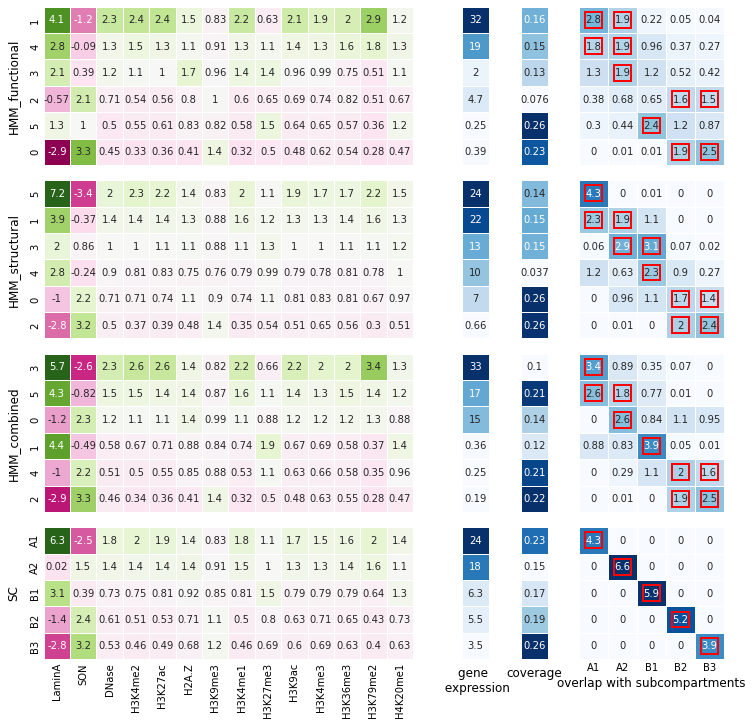

In [11]:
fig, axs = plt.subplots(4,4, figsize=(12.5,12), sharex = 'col', sharey = 'row',
                       gridspec_kw={'width_ratios': [14, 1, 1, 5],
                                   'height_ratios': [6,6,6,5]})

for m,(method) in enumerate(['HMM_functional', 'HMM_structural', 'HMM_combined', 'SC']):
    
    sns.heatmap(enrichments[method].iloc[orders[method][::-1],:], cmap="PiYG", center = 1, linewidths=.5, 
                square = True, cbar = False, annot = True, ax = axs[m,0])
    axs[m,0].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,0].set_yticklabels('')
    axs[m,0].set_ylabel(method, fontsize = 12, labelpad = 10)

    sns.heatmap(expr_stats[method].iloc[orders[method][::-1]], ax = axs[m,1], cmap = 'Blues', annot = True, 
                cbar = False, square = True, linewidths=.5)
    axs[m,1].set_ylabel('')
    axs[m,1].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,1].set_xticklabels([])

    sns.heatmap(coverages[method].iloc[orders[method][::-1]], ax = axs[m,2], cmap = 'Blues', annot = True, 
                cbar = False, square = True, linewidths=.5)
    axs[m,2].set_ylabel('')
    axs[m,2].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,2].set_xticklabels([])
    
    #if m != 2:
    sns.heatmap(overlaps[method], ax = axs[m,3], cbar = False, cmap = 'Blues', annot = True,
       linewidths = 0.5, vmin = 0, vmax = 6)
    axs[m,3].set_ylabel('')
    axs[m,3].tick_params(axis=u'both', which=u'both',length=0)
    #axs[m,3].set_xticklabels([])
    axs[m,3].set_xlabel('')
    for i in range(pvalues[method].shape[0]):
        for j in range(pvalues[method].shape[1]):
            if pvalues[method][i,j] < 2.2e-16:
                axs[m,3].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))

axs[3,1].set_xlabel('gene \n expression', fontsize = 12)
axs[3,2].set_xlabel('coverage', fontsize = 12)
axs[3,3].set_xlabel('overlap with subcompartments', fontsize = 12)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.1)

#fig.savefig('results/func_struct_comp.png', dpi = 300,bbox_inches='tight',facecolor='white', transparent=False)